In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%watermark

Last updated: 2024-07-18T16:19:23.221986-04:00

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

Compiler    : MSC v.1937 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 16
Architecture: 64bit



In [2]:
# Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import os

from func_utils import *

# Display and graph options

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Customize the font and title size
custom_params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "Arial"
}
sns.set_context("notebook", rc=custom_params)

# Set a color palette
sns.set_palette("Set2") 

# Set global option to display numbers in plain format
pd.set_option('display.float_format', '{:.2f}'.format)

# Filter warnings and seeds
import warnings
import random

warnings.filterwarnings('ignore')
random.seed(1234)

In [55]:
# Data 

data_tmp = pd.read_csv('DATA/base_main.csv')

In [56]:
data_tmp.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Transaction_Date2,Month,Coupon_Code,Discount_pct,Discount_pct_ajus,Invoice,Gender,Location,Tenure_Months,month
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,2019-01-01,Jan,ELEC10,10.00,10.00,194.37,M,Chicago,12,1
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,2019-01-01,Jan,ELEC10,10.00,10.00,194.37,M,Chicago,12,1
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,...,2019-01-01,Jan,OFF10,10.00,10.00,9.01,M,Chicago,12,1
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,...,2019-01-01,Jan,SALE10,10.00,0.00,109.93,M,Chicago,12,1
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,...,2019-01-01,Jan,AIO10,10.00,10.00,28.13,M,Chicago,12,1


# 3. Performing Customer Segmentation
### 3.1. Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver, Standard customers and define strategy on the same.

RFM analysis is a data driven customer behavior segmentation technique. RFM stands for recency, frequency, and monetary value.
The  idea is to segment customers based on when their last purchase was, how often they’ve purchased in the past, and how much they’ve spent overall.


To calculate the RFM score, I will follow these steps:

1. Assign scores: For each of the RFM factors, assign scores on a scale from 1 to 5, where 5 is the highest value (most recent, most frequent, highest monetary).
2. Score Recency: Customers who purchased most recently get the highest scores.
3. Score Frequency: Customers who purchased most frequently get the highest scores.
4. Score Monetary: Customers who spent the most get the highest scores.

Combine the scores: Concatenate the individual scores to get a three-digit number representing the RFM score. For example, if a customer has Recency = 5, Frequency = 3, and Monetary = 4, their RFM score would be 534.

*Important* to notice that are other mehtods and aggregations to the final score. For example, we can assign different weights based on the importance of each variable.

In [70]:
# Recency
data_tmp['Transaction_Date'] = pd.to_datetime(data_tmp['Transaction_Date'])

# Calculating a reference date (last purchase)
data_ref = data_tmp['Transaction_Date'].max()

# Grouping and calculating the recency
recency_tmp = data_tmp.groupby('CustomerID')['Transaction_Date'].agg('max').reset_index(name = 'last_purchase')
recency_tmp['recency_days'] = (data_ref - recency_tmp['last_purchase']).dt.days

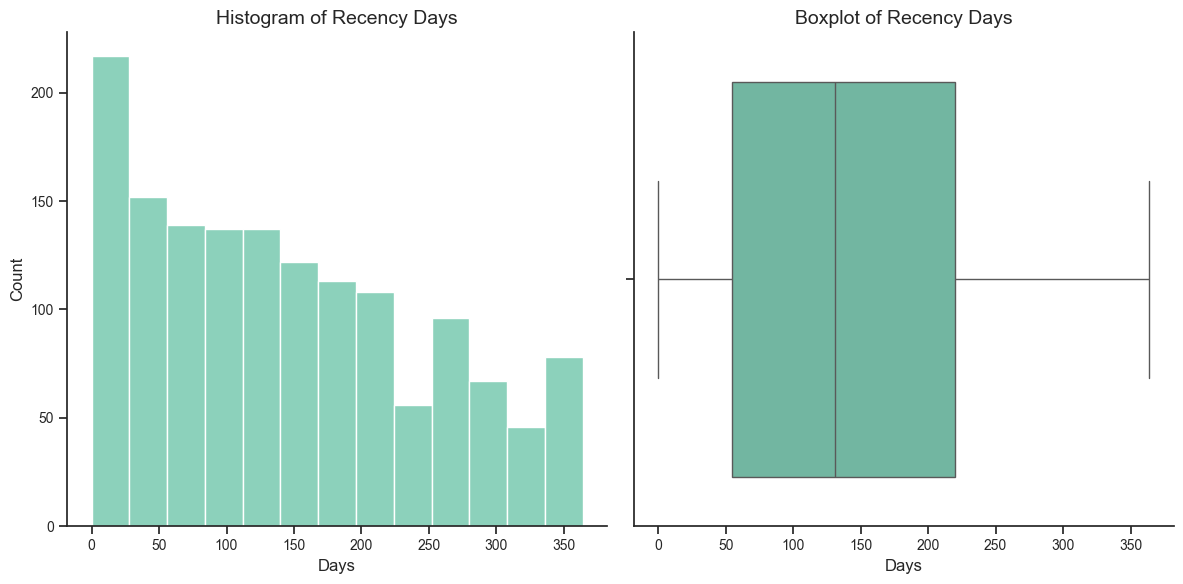

In [58]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
sns.histplot(recency_tmp['recency_days'], ax=axes[0])
axes[0].set_title('Histogram of Recency Days')
axes[0].set_xlabel('Days')  # Rótulo do eixo X
axes[0].set_ylabel('Count')  # Rótulo do eixo Y

# Boxplot
sns.boxplot(x=recency_tmp['recency_days'], ax=axes[1])
axes[1].set_title('Boxplot of Recency Days')
axes[1].set_xlabel('Days')  # Rótulo do eixo X

# Adjust layout
plt.tight_layout()
plt.show()

In [92]:
# Assign the labels for recency

recency_tmp['recency_score'] = pd.qcut(recency_tmp['recency_days'], 5, labels = [5,4,3,2,1])
recency_tmp['recency_score'] = recency_tmp['recency_score'].astype(int)

In [83]:
# Frequency

frequency = data_tmp['CustomerID'].value_counts().reset_index(name = 'frequency')
frequency['frequency'].describe()

count   1468.00
mean      36.05
std       50.89
min        1.00
25%       10.00
50%       21.00
75%       46.00
max      695.00
Name: frequency, dtype: float64

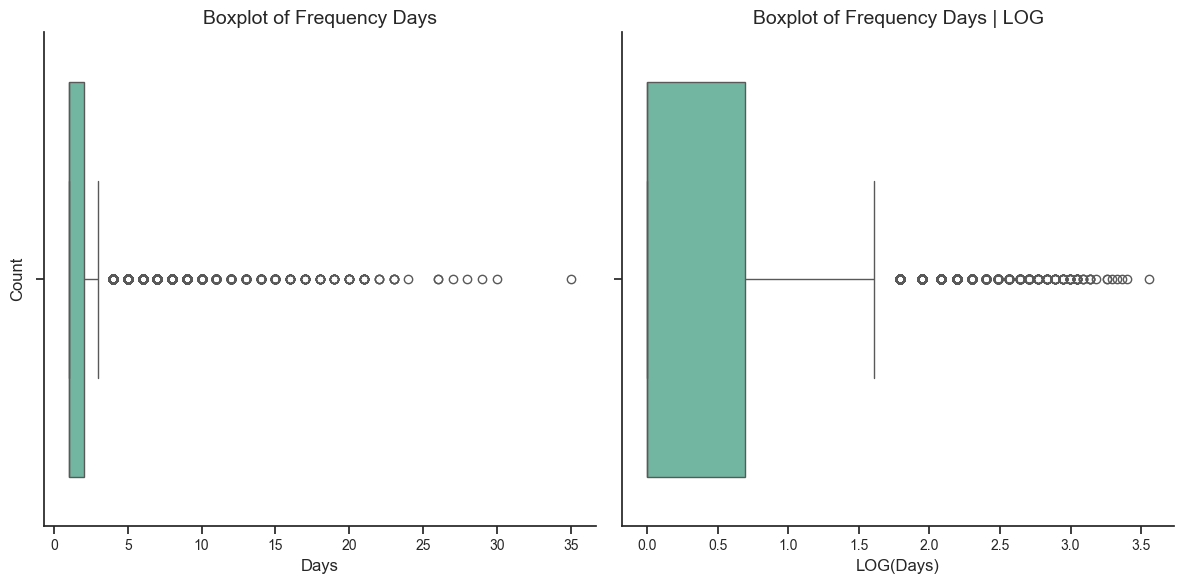

In [72]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

frequency_log = np.log(frequency['frequency'])

# Histogram
sns.boxplot(x = frequency['frequency'], ax=axes[0])
axes[0].set_title('Boxplot of Frequency Days')
axes[0].set_xlabel('Days')  
axes[0].set_ylabel('Count')  

# Boxplot
sns.boxplot(x=frequency_log, ax=axes[1])
axes[1].set_title('Boxplot of Frequency Days | LOG')
axes[1].set_xlabel('LOG(Days)')  


plt.tight_layout()
plt.show()

In [85]:
# Assign the labels for frequency

frequency['frequency_score'] = pd.qcut(frequency['frequency'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop').astype(int)

In [86]:
# Monetary

monetary = data_tmp.groupby(['CustomerID'])['Invoice'].agg('sum').reset_index()

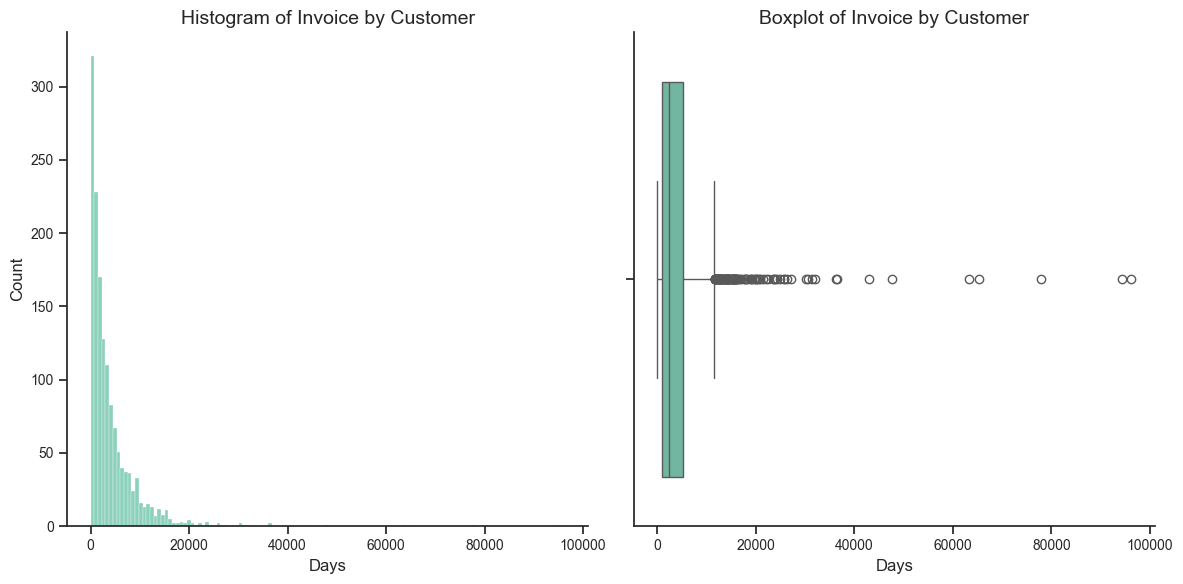

In [87]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
sns.histplot(monetary['Invoice'], ax=axes[0])
axes[0].set_title('Histogram of Invoice by Customer')
axes[0].set_xlabel('Days')  
axes[0].set_ylabel('Count') 

# Boxplot
sns.boxplot(x=monetary['Invoice'], ax=axes[1])
axes[1].set_title('Boxplot of Invoice by Customer')
axes[1].set_xlabel('Days')  

# Adjust layout
plt.tight_layout()
plt.show()

In [89]:
# Assign labels for monetary

monetary['invoice_score'] = pd.qcut(monetary['Invoice'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop').astype(int)


In [94]:
# Combining the bases

data_rfm_tmp = monetary.merge(frequency, on='CustomerID', how='left').merge(recency_tmp, on='CustomerID', how='left')
data_rfm_tmp.head(3)

,CustomerID,Invoice,invoice_score,frequency,frequency_score,last_purchase,recency_days,recency_score
0,12346,200.98,1,2,1,2019-09-15,107,3
1,12347,17772.35,5,60,5,2019-11-02,59,4
2,12348,2046.76,3,23,3,2019-10-19,73,4
